In [1]:
from copy import deepcopy
from pathlib import Path
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas import DataFrame
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from trap.frame_emitter import Camera, Track
from trap.tracker import FinalDisplacementFilter, TrackReader
from trap.utils import ImageMap


# 0. Training options

In [2]:

# Training options
from trap.base import DistortedCamera


input_seq_length = 36
output_seq_length = 36

lr = 0.00005
num_epochs = 100
batch_size = 512
hidden_size = 32
num_gru_layers = 1
grad_clip = 1.0
scheduled_sampling_decay = 10
dropout = 0.

# As opposed to point-wise (assumes Gaussian)
# probabilistic = True

# use_attention = True

path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = DistortedCamera.from_paths(calibration_path, homography_path, 12)

snapshot_path = Path("../DATASETS/hof3/output.png")


# when using a map encoder:
image_path = Path("../DATASETS/hof3/map-undistorted-H-2.png")
assert image_path.exists()

CACHE_DIR = Path("/tmp/cache-custom-rnn")
cache_path = Path(CACHE_DIR)
cache_path.mkdir(parents=True, exist_ok=True)


(1440, 2560, 3)
[[     1.7927      12.995]
 [     17.895      14.859]]
[[     1.7927      12.995]
 [     17.895      14.859]]


ValueError: x and y must have same first dimension, but have shapes (2, 2) and (1, 1, 2)

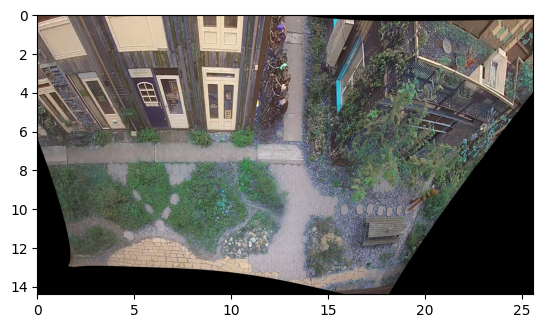

In [3]:
from trap.utils import convert_world_space_to_img_space


frame_img = cv2.imread(snapshot_path)
print(frame_img.shape)
undistorted_img = cv2.undistort(frame_img, camera.mtx, camera.dist, None, camera.newcameramtx)
# dst_img = cv2.warpPerspective(undistorted_img,convert_world_space_to_img_space(camera.H),(camera.w,camera.h))
dst_img = cv2.warpPerspective(undistorted_img,convert_world_space_to_img_space(camera.H),(camera.w,camera.h))

point_coordinates = [[0, 1440], [2560, 1440]]
coords = cv2.undistortPoints(np.array([point_coordinates]).astype('float32'), camera.mtx, camera.dist, None, camera.newcameramtx)
coords = cv2.perspectiveTransform(np.array(coords),camera.H)
print( coords.reshape((coords.shape[0],2)))
print(coords[:,0])

plt.imshow(dst_img, extent=(0, dst_img.shape[1]/100, dst_img.shape[0]/100,0)),
plt.plot(coords[:,0], coords[:1], 'ro')

# 1. Data loading

In [3]:
in_fields = [ 'x', 'y', 'dx', 'dy']
out_fields = ['dx', 'dy']

In [4]:
from trap.tracker import Smoother
from typing import List

def load_tracks():
    reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)

    smoother = Smoother()
    # 
    # make sure we have all points for all tracks
    tracks: List[Track] = [t.get_with_interpolated_history() for t in reader]
    # t = Smoother().smooth_track(t)
    track_filter = FinalDisplacementFilter(2)
    tracks = track_filter.apply(tracks, camera)
    tracks = [smoother.smooth_track(t) for t in tracks]

    return tracks

    print(f"Loaded {len(tracks)}")

In [5]:
tracks = load_tracks()

In [7]:
len(tracks)

0

In [6]:
reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)


In [25]:

track = reader._tracks["48"]

track = track.get_with_interpolated_history()
history = track.get_projected_history(H=None, camera=camera)
print("actual", len(track.history), "projected", len(history))

actual 26 projected 1


In [5]:
# split training & validation:
def split_tracks(tracks: List[Track]):
    np.random.shuffle(tracks)
    test_offset_idx = int(len(tracks) * .8)

    training_tracks, test_tracks = tracks[:test_offset_idx], tracks[test_offset_idx:]
    return training_tracks, test_tracks


In [6]:
def create_dataset(tracks: list[Track], input_seq_length: int, output_seq_length: int, in_fields: list[str], out_fields: list[str], camera: Camera, only_last=False, device='cpu'):
    encoder_X, decoder_X, decoder_y, = [], [], []
    # factor = SAMPLE_STEP if SAMPLE_STEP is not None else 1
    for track in tqdm(tracks):
        # track = reader.get(track_id)
        if len(track.history) < 2:
            print(track.track_id, "too short")
        df: DataFrame = track.to_flat_dataframe(camera)
        # df = data.loc[track_id]
        # print(df)
        # start_frame = min(df.index.tolist())
        for timestep in range(df.shape[0] - (input_seq_length + output_seq_length) + 1):

            # enc_inputs: (input seq len, num features)
            # print(df[timestep:timestep+input_seq_length][['velocity_x', 'velocity_y']])
            past = deepcopy(df[timestep : timestep + input_seq_length][in_fields])
            future = deepcopy(df[timestep + input_seq_length : timestep + input_seq_length + output_seq_length][out_fields])
            # enc_inputs_at_t = deepcopy(df[timestep : timestep + input_seq_length][in_fields])
            # dec_at_t = deepcopy(df[timestep + input_seq_length - 1 : timestep + input_seq_length + output_seq_length])
            # dec_targets: (output seq len, num features)
            # dec_inputs_at_t = deepcopy(dec_at_t[:-1][in_fields])
            # dec_targets: (output seq len, num targets)
            # dec_targets_at_t = deepcopy(dec_at_t[1:][out_fields])

            if past.isna().any().any():
                print("nan in past", track.track_id, timestep)
            elif future.isna().any().any():
                print("nan in future", track.track_id, timestep)
            else:
                encoder_X.append(past)
                decoder_y.append(future)
            
        # # for step in range(len(df)-window-1):
        #     i = int(start_frame) + (step*factor)
        #     # print(step, int(start_frame), i)
        #     feature = df.loc[i:i+(window*factor)][in_fields]
        #     # target = df.loc[i+1:i+window+1][out_fields]
        #     # print(i, window*factor, factor, i+window*factor+factor, df['idx_in_track'])
        #     # print(i+window*factor+factor)
        #     if only_last:
        #         target = df.loc[i+window*factor+factor][out_fields]
        #     else:
        #         target = df.loc[i+factor:i+window*factor+factor][out_fields]


            # encoder_X.append(enc_inputs_at_t.values)
            # decoder_X.append(dec_inputs_at_t.values)
            # decoder_y.append(dec_targets_at_t.values)
    
    return TensorDataset(
        torch.tensor(np.array(encoder_X), device=device, dtype=torch.float), 
        torch.tensor(np.array(decoder_y), device=device, dtype=torch.float)
    )
    
    # return {'enc_inputs': torch.tensor(np.array(encoder_X), device=device, dtype=torch.float), 
    #       'dec_inputs': torch.tensor(np.array(decoder_X), device=device, dtype=torch.float), 
    #       'dec_outputs': torch.tensor(np.array(decoder_y), device=device, dtype=torch.float)}


In [7]:
def create_datasets():
    tracks = load_tracks()
    training_tracks, test_tracks = split_tracks(tracks)
    dataset_train = create_dataset(training_tracks, input_seq_length, output_seq_length, in_fields, out_fields, camera, False, device)
    dataset_test = create_dataset(test_tracks, input_seq_length, output_seq_length, in_fields, out_fields, camera, False, device)
    return dataset_train, dataset_test    

In [8]:
dataset_cache_file = (CACHE_DIR / 'datasets.p')
if dataset_cache_file.exists():
    dataset_train, dataset_test = torch.load(dataset_cache_file)
    print('loaded', dataset_cache_file)
else:
    dataset_train, dataset_train = create_datasets()
    torch.save((dataset_train, dataset_test), dataset_cache_file)
    print('saved', dataset_cache_file)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [13]:
dataset_train.tensors[0].isnan().any(), dataset_train.tensors[1].isnan().any()

(tensor(False, device='cuda:0'), tensor(False, device='cuda:0'))

In [14]:
len(dataset_train), input_seq_length, output_seq_length

(210962, 36, 36)

In [10]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Probablistic Recurrent VAE

In [37]:
def integrate_output_to_input(output_feature: torch.Tensor, input_feature: torch.Tensor):
    """use four params (x,y, dx, dy) to predict dx, dy
    integrate prediction back into input to get a new feature
    """
    # input_feature (batch_size, ?, num in_fields)
    # output_feature (batch_size, ?, num out_fields)
    new_positions = input_feature[:,:,0:2] + output_feature
    return torch.cat((new_positions, output_feature), axis=2)
    # return new_feature
    # return torch.tensor([
    #     input_feature[0] + output_feature[0],
    #     input_feature[1] + output_feature[1],
    #     output_feature[0],
    #     output_feature[1],
    # ], device=input_feature.device)


# VAE

class RPVAE(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, latent_dim=16, future_len=12):
        super().__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.future_len = future_len

        # Encoder: encodes past trajectory to latent space
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)

        # Decoder: decodes z to future trajectory
        self.decoder_input = nn.Linear(latent_dim + input_size, hidden_size)
        self.decoder_lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output = nn.Linear(hidden_size, 2)

    def encode(self, x):
        _, (h_n, _) = self.encoder(x)  # h_n: (1, batch, hidden)
        h_n = h_n.squeeze(0)
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, start_pos):
        # Initial hidden state from latent + start position
        batch_size = z.size(0)
        dec_input = torch.cat([z, start_pos], dim=1)
        h = torch.tanh(self.decoder_input(dec_input)).unsqueeze(0)  # (1, batch, hidden)
        c = torch.zeros_like(h)

        outputs = []
        input_step = start_pos.unsqueeze(1)  # (batch, 1, 2)
        for _ in range(self.future_len):
            # print('input_step', input_step.shape)
            # print('input_step', input_step)
            out, (h, c) = self.decoder_lstm(input_step, (h, c))
            pred = self.output(out)
            outputs.append(pred.squeeze(1))
            # print('output_step', pred.shape)
            input_step = integrate_output_to_input(pred, input_step) # feed predicted position as input
            
            # input_step = pred  

        return torch.stack(outputs, dim=1)

    def forward(self, past_traj):
        # past_traj: (batch_size, history_len, num parameters)
        mu, logvar = self.encode(past_traj)
        z = self.reparameterize(mu, logvar)
        
        last_pos = past_traj[:, -1, :]  # last observed position
        # print('last_pos', last_pos)
        future_pred = self.decode(z, last_pos)
        return future_pred, mu, logvar

In [38]:
def vae_loss(recon, target, mu, logvar):
    recon_loss = nn.MSELoss()(recon, target)
    # KL Divergence
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

In [39]:
def train_rpvae(model, dataloader, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for past, future in tqdm(dataloader):
            pred, mu, logvar = model(past)
            loss, recon_loss, kl_loss = vae_loss(pred, future, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f} (total:{total_loss})")

In [40]:
def predict_multiple(model, past_traj, num_samples=5):
    model.eval()
    predictions = []
    with torch.no_grad():
        for _ in range(num_samples):
            pred, _, _ = model(past_traj.unsqueeze(0))
            predictions.append(pred.squeeze(0))
    return torch.stack(predictions)  # (num_samples, future_len, 2)

# Run training

In [41]:
# Train model
model = RPVAE(input_size=len(in_fields), future_len=output_seq_length).to(device)
train_rpvae(model, dataloader_train)


  0%|          | 0/1649 [00:00<?, ?it/s]

100%|██████████| 1649/1649 [00:27<00:00, 60.71it/s]


Epoch 1, Loss: 0.0015 (total:2.4276419173402246)


100%|██████████| 1649/1649 [00:27<00:00, 60.52it/s]


Epoch 2, Loss: 0.0006 (total:0.980240458418848)


100%|██████████| 1649/1649 [00:25<00:00, 63.70it/s]


Epoch 3, Loss: 0.0006 (total:0.940998741221847)


100%|██████████| 1649/1649 [00:27<00:00, 59.99it/s]


Epoch 4, Loss: 0.0006 (total:0.9100368080544285)


100%|██████████| 1649/1649 [00:25<00:00, 64.31it/s]


Epoch 5, Loss: 0.0005 (total:0.8973619830212556)


100%|██████████| 1649/1649 [00:25<00:00, 63.93it/s]


Epoch 6, Loss: 0.0005 (total:0.8762864287418779)


100%|██████████| 1649/1649 [00:25<00:00, 63.51it/s]


Epoch 7, Loss: 0.0005 (total:0.8653568502340931)


100%|██████████| 1649/1649 [00:26<00:00, 63.40it/s]


Epoch 8, Loss: 0.0005 (total:0.858748087339336)


100%|██████████| 1649/1649 [00:26<00:00, 62.45it/s]


Epoch 9, Loss: 0.0005 (total:0.8507893867790699)


100%|██████████| 1649/1649 [00:26<00:00, 63.08it/s]


Epoch 10, Loss: 0.0005 (total:0.8442291679384653)


100%|██████████| 1649/1649 [00:26<00:00, 63.12it/s]


Epoch 11, Loss: 0.0005 (total:0.8402256505505648)


100%|██████████| 1649/1649 [00:26<00:00, 63.25it/s]


Epoch 12, Loss: 0.0005 (total:0.8351299523201305)


100%|██████████| 1649/1649 [00:26<00:00, 62.70it/s]


Epoch 13, Loss: 0.0005 (total:0.8282983377866913)


100%|██████████| 1649/1649 [00:26<00:00, 63.07it/s]


Epoch 14, Loss: 0.0005 (total:0.8267594532226212)


100%|██████████| 1649/1649 [00:26<00:00, 63.20it/s]


Epoch 15, Loss: 0.0005 (total:0.8221607875893824)


100%|██████████| 1649/1649 [00:26<00:00, 62.41it/s]


Epoch 16, Loss: 0.0005 (total:0.8198444427980576)


100%|██████████| 1649/1649 [00:26<00:00, 61.50it/s]


Epoch 17, Loss: 0.0005 (total:0.8170247735979501)


100%|██████████| 1649/1649 [00:26<00:00, 62.95it/s]


Epoch 18, Loss: 0.0005 (total:0.8117570877220714)


100%|██████████| 1649/1649 [00:26<00:00, 62.83it/s]


Epoch 19, Loss: 0.0005 (total:0.8099762515848852)


100%|██████████| 1649/1649 [00:26<00:00, 63.02it/s]

Epoch 20, Loss: 0.0005 (total:0.8074558652297128)


In [60]:
model.future_len = 100
#model.future_len = 36

In [89]:

# Inference on one sample
past, future = dataset_test[29000]
samples = predict_multiple(model, past)

In [90]:
def integrate_samples(first_position, samples):
    # first_position: (2) : [x,y]
    # samples: (num_samples, future_len, 2 [dx, dy])
    
    output = []
    for sample in samples:
        s = torch.cumsum(sample, axis=0) + first_position
        output.append(s)
    # return torch.cumsum(samples)
    # print(output[0].shape)
    return torch.stack(output, dim=0)

future_xy = integrate_samples(past[-1][:2], [future])
samples = integrate_samples(past[-1][:2], samples)

In [91]:
past, future, samples = past.cpu(), future_xy[0].cpu(), samples.cpu()

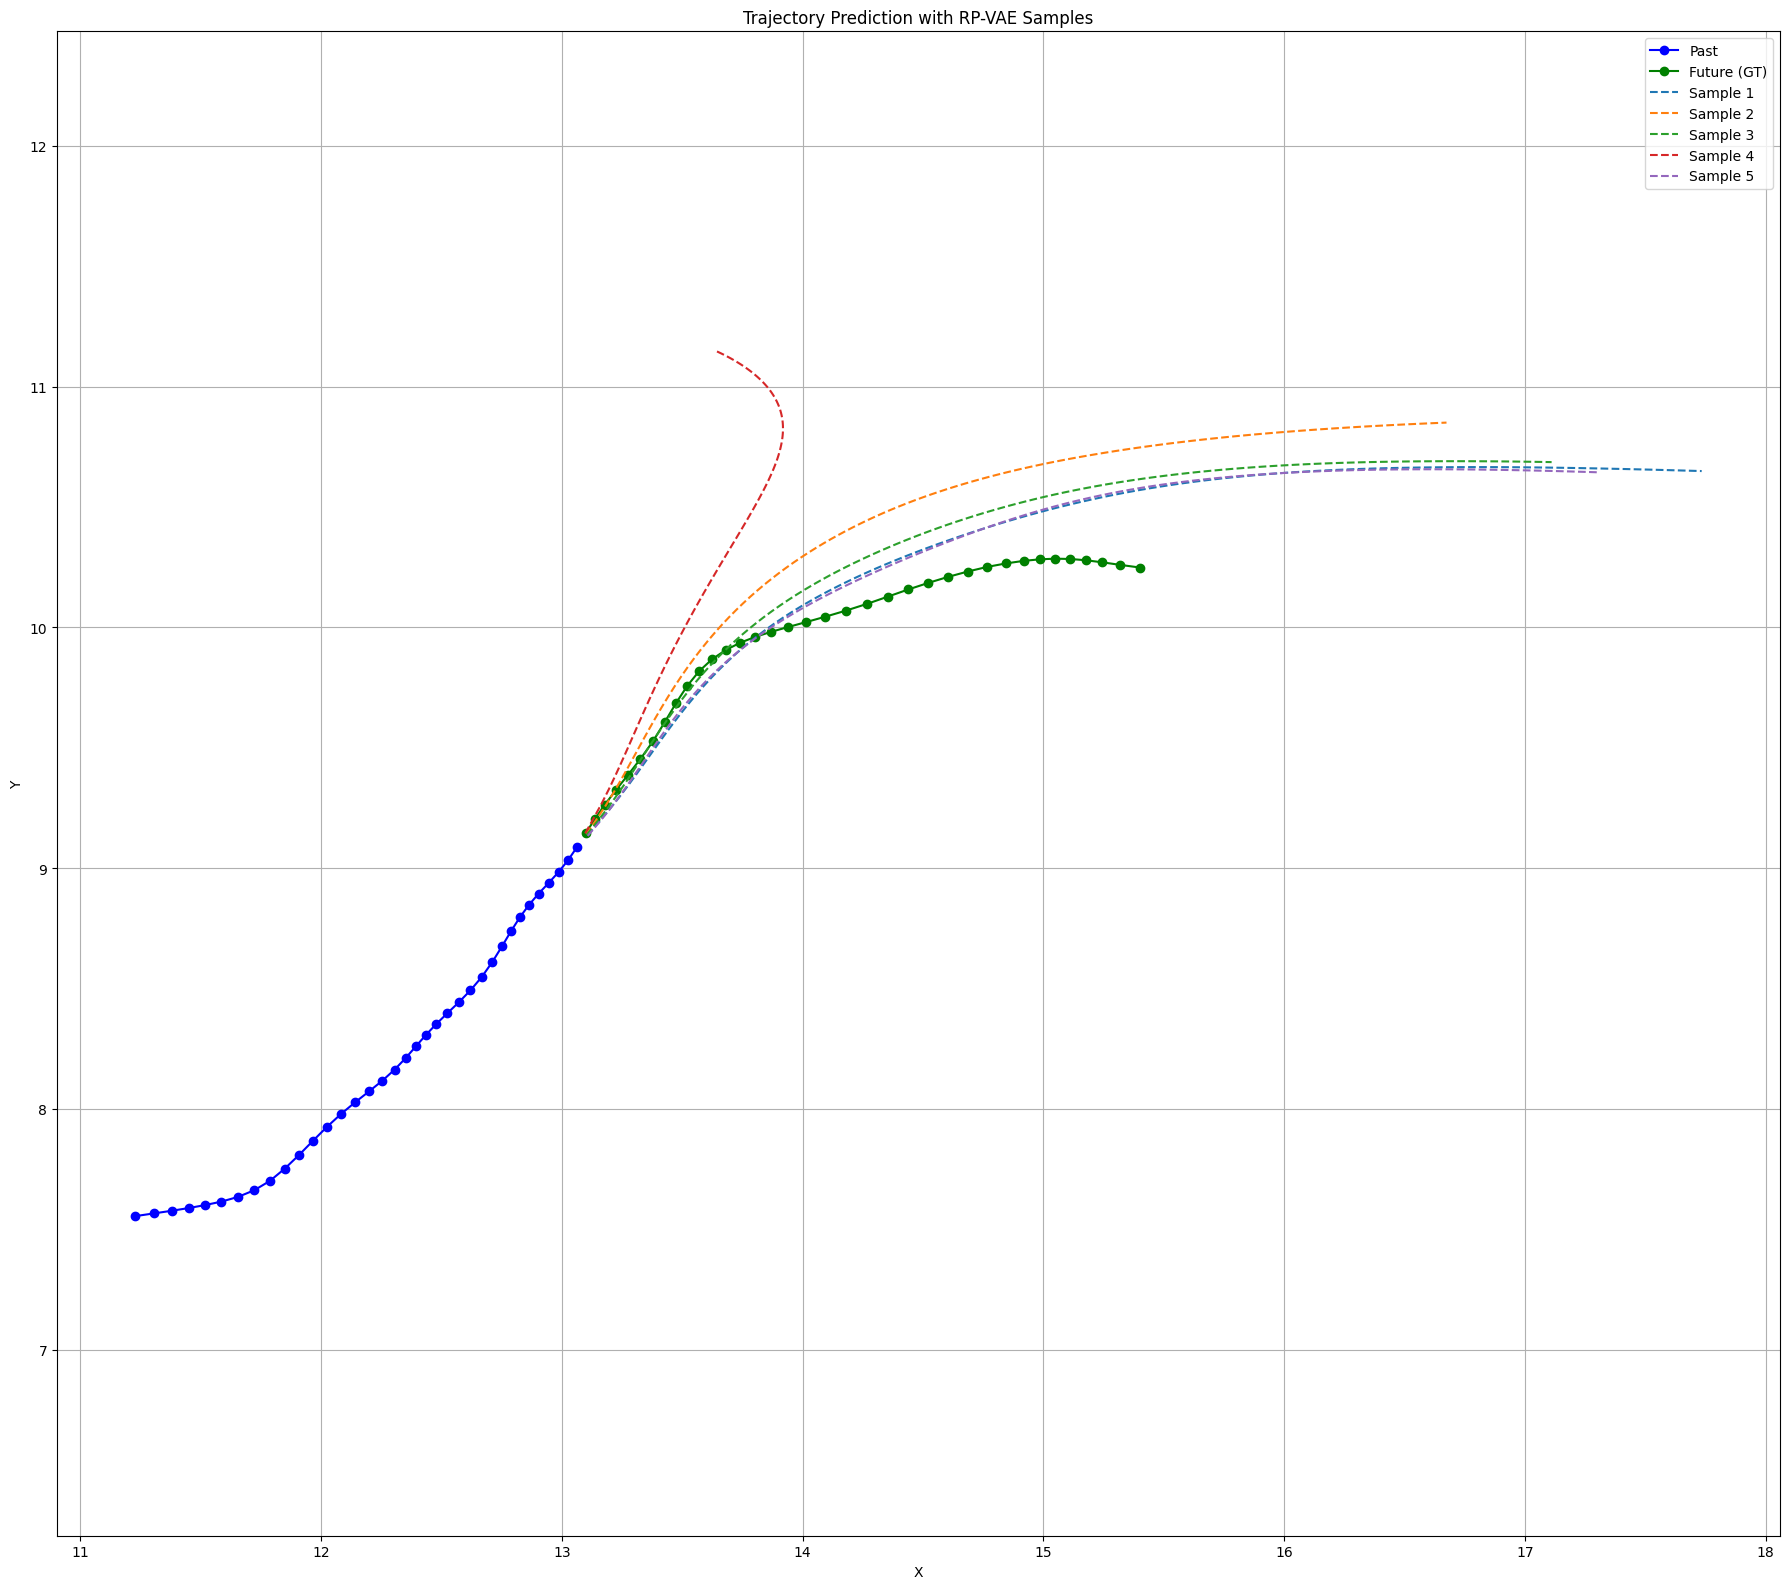

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.plot(past[:, 0], past[:, 1], 'b-o', label='Past')
plt.plot(future[:, 0], future[:, 1], 'g-o', label='Future (GT)')

for i in range(samples.shape[0]):
    plt.plot(samples[i, :, 0], samples[i, :, 1], '--', label=f'Sample {i+1}')

plt.legend()
plt.title('Trajectory Prediction with RP-VAE Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# TODO

* Stop prediction in model.forward() based on out of bounds. Only in inference mode.
* variable history
* Duplicate this file and check other notebook for training improvements
    * Error/loss metric
    * Add attention to network?
* Check Trajectron paper on "Overshoot" (use _map_)
* Ask for suggestions for anomaly metric
